In [1]:
from DatasetGenerator import DatasetGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


- **Complexity and Overfitting**: Polynomial kernels can become more complex as the degree \(d\) increases, potentially leading to overfitting. RBF kernels, with their locality-sensitive nature, can fit complex shapes but also risk overfitting if $\gamma$ is set too high.
- **Computational Efficiency**: RBF kernels generally involve less computation for training and prediction, as they are less sensitive to the number of features in the dataset compared to high-degree polynomial kernels.
- **Flexibility in Capturing Relationships**: RBF is more flexible in capturing a wide variety of shapes in the decision boundary, whereas polynomial kernels are more structured and specific in the types of relationships they model.



In [2]:
dataset_generator = DatasetGenerator()

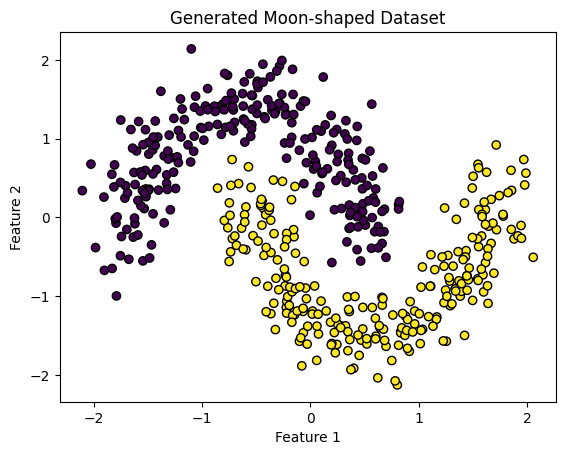

In [3]:
nonlinear_dataset = dataset_generator.get_nonlinear_dataset()
plt.scatter(nonlinear_dataset['Feature1'], nonlinear_dataset['Feature2'], c=nonlinear_dataset['Label'], cmap='viridis', marker='o', edgecolors='k')
plt.title("Generated Moon-shaped Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [4]:
def plot_svm (clf, X_train, y_train, X_test, y_test):
    x0s = np.linspace(min(X_train[:,0])-0.5,max(X_train[:,0])+0.5, 100)
    x1s = np.linspace(min(X_train[:,1])-0.5,max(X_train[:,1])+0.5, 100)
    x0, x1 = np.meshgrid(x0s,x1s) 
    X_mesh = np.c_[x0.ravel(), x1.ravel()] 
    y_pred = clf.predict(X_mesh).reshape(x0.shape) 
    y_decision = clf.decision_function(X_mesh).reshape(x0.shape)

    plt.figure(figsize=(16, 9)) 
    plt.scatter(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], s=80, c="g", label="Class 0")
    plt.scatter(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], s=80, c="b", label="Class 1")
    plt.scatter(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], s=80, c="g")
    plt.scatter(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], s=80, c="b")

    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=80, c="r", label="Support Vectors")

    plt.contourf(x0,x1, y_pred, cmap = plt.cm.brg, alpha = 0.1)
    plt.contourf(x0,x1, y_decision, cmap = plt.cm.brg, alpha = 0.2)
    plt.contour(x0, x1, y_decision, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.legend(loc="lower right")
    plt.axis("auto")
    plt.grid(True, which='both')
    plt.xlabel("x1")
    plt.ylabel("x2") 

In [5]:
def tune(model, params, X_train, y_train):
    rnd_search = RandomizedSearchCV(model, param_distributions =params, n_iter = 50, cv = 5, random_state=40)
    rnd_search.fit(X_train, y_train)
    print("best hyper-parameter value: ", rnd_search.best_params_)
    best_model = rnd_search.best_estimator_
    return best_model

# RBF

The RBF kernel is defined as $e^{(-\gamma \|x - x'\|^2)}$, where $\|x - x'\|$ is the Euclidean distance between two feature vectors, and $\gamma$ is a scale factor.

- RBF can handle nonlinear relationships between features more flexibly than the polynomial kernel.
- It's a locality-sensitive kernel, meaning it creates a decision boundary considering the local behavior of the data. The scale factor $\gamma$ determines how much influence a single training example has.
- The larger $\gamma$ is, the closer other examples must be to be affected.


In [9]:
X = np.array(nonlinear_dataset[['Feature1', 'Feature2']].values)
y = np.array(nonlinear_dataset['Label'].to_list())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SVC(kernel="rbf")
parameters = {"C": uniform(0,20), "gamma":uniform(0, 1)}
best_model = tune(model, parameters,  X_train, y_train)

best hyper-parameter value:  {'C': 16.27937039885991, 'gamma': 0.7086451521631987}


In [10]:
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        57

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [11]:
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Confusion Matrix:
[[43  0]
 [ 0 57]]


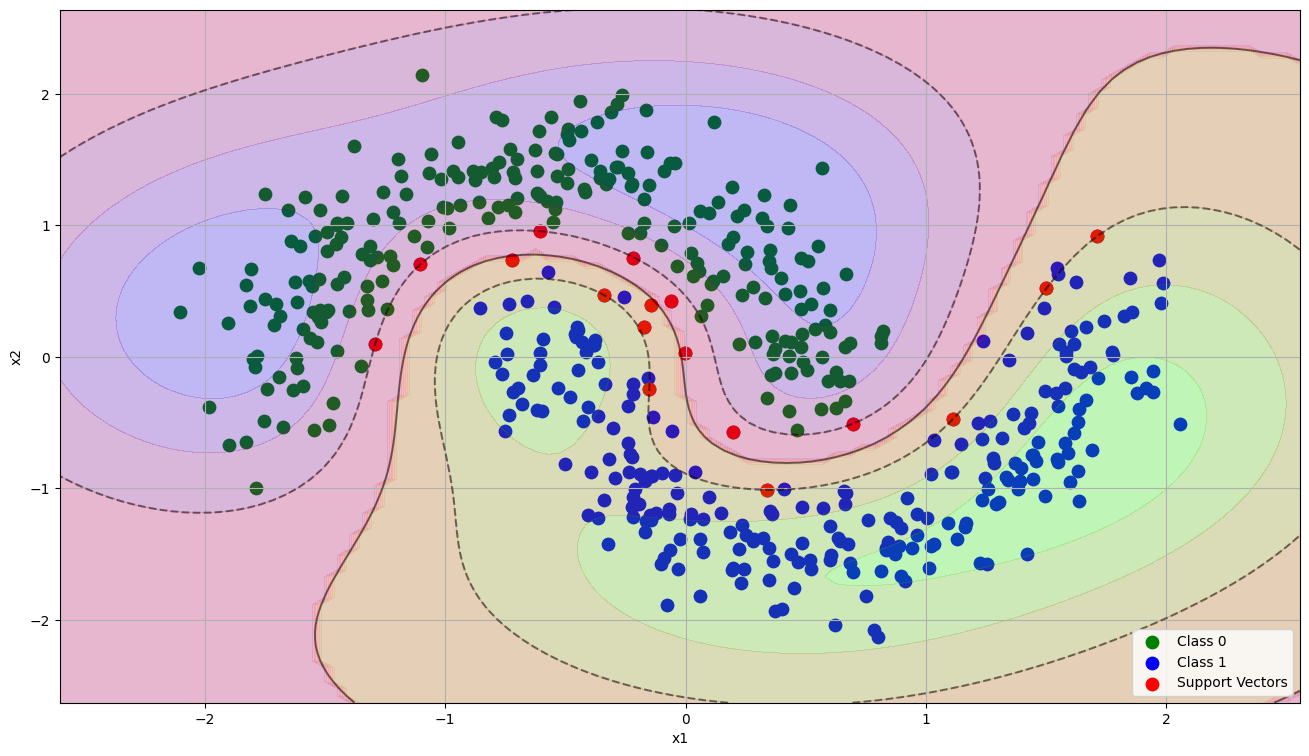

In [12]:
#with best C value
plot_svm (best_model, X_train, y_train, X_test, y_test)

hyper-parameter value:  {'C':float range 0 to 20, gamma': 0.7086451521631987} 

### Impact of Changing `C` in RBF Kernel SVM:

1. **Low `C` Values (e.g., 0.1, 1)**:
   - **Support Vectors**: Tends to use fewer support vectors as the model emphasizes a smoother, more generalized decision boundary.
   - **Decision Boundaries**: Produces more generalized decision boundaries with broader margins. This is because the model is penalized less for misclassifications and focuses more on maximizing the margin.
   - **Complexity**: The model is simpler, reducing the risk of overfitting.
   - **Train and Test Error**: May lead to higher training error (lower fit to the training data) but potentially better generalization, resulting in lower test error.

2. **Moderate `C` Values (e.g., 5, 10)**:
   - **Support Vectors**: A moderate number of support vectors are used, indicating a balance between fitting to the training data and maintaining generalization.
   - **Decision Boundaries**: More complex than with low `C`, but not overly tailored to the training data.
   - **Complexity**: Increased complexity compared to low `C`, but still maintains a balance to avoid severe overfitting.
   - **Train and Test Error**: Generally offers a good balance between training and test accuracy.

3. **High `C` Values (e.g., 15, 20)**:
   - **Support Vectors**: Uses more support vectors as the model becomes highly sensitive to the training data.
   - **Decision Boundaries**: Highly complex and tightly fitted to the training data, with narrow margins.
   - **Complexity**: Increased model complexity, with a high risk of overfitting.
   - **Train and Test Error**: High training accuracy but potentially high test error due to overfitting.

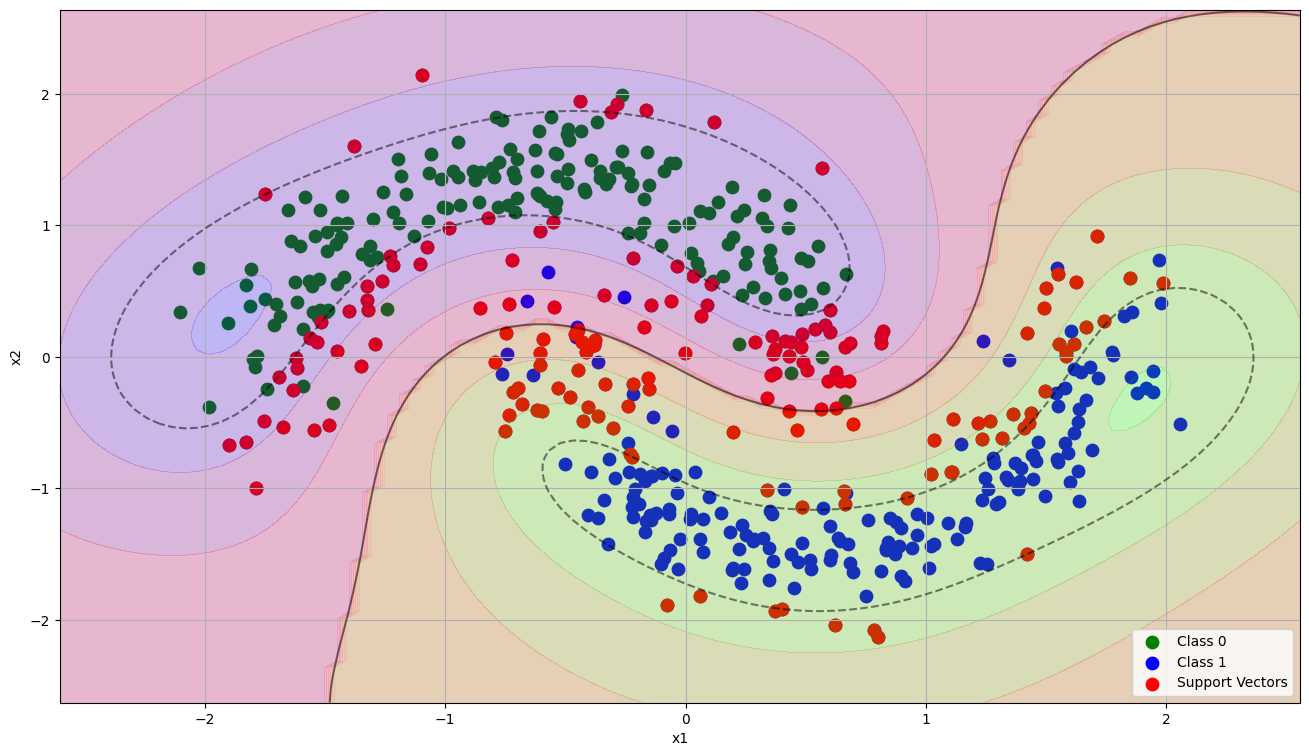

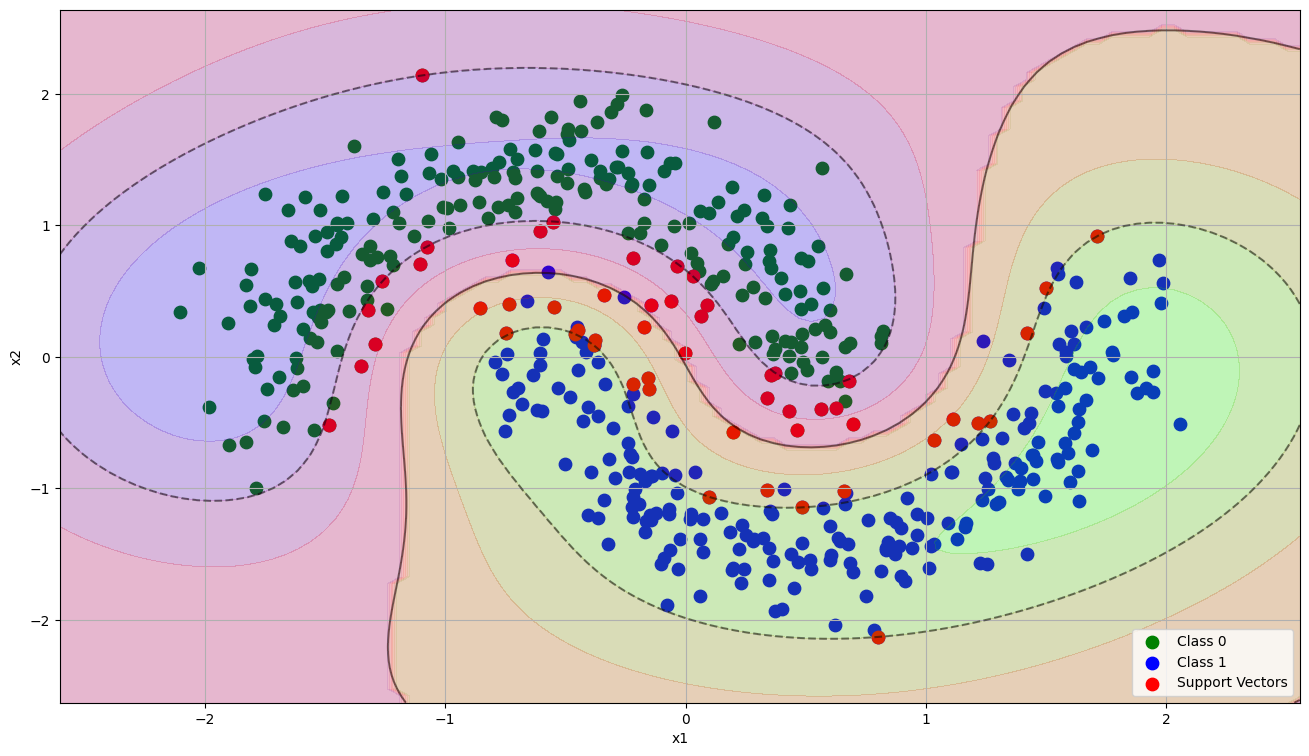

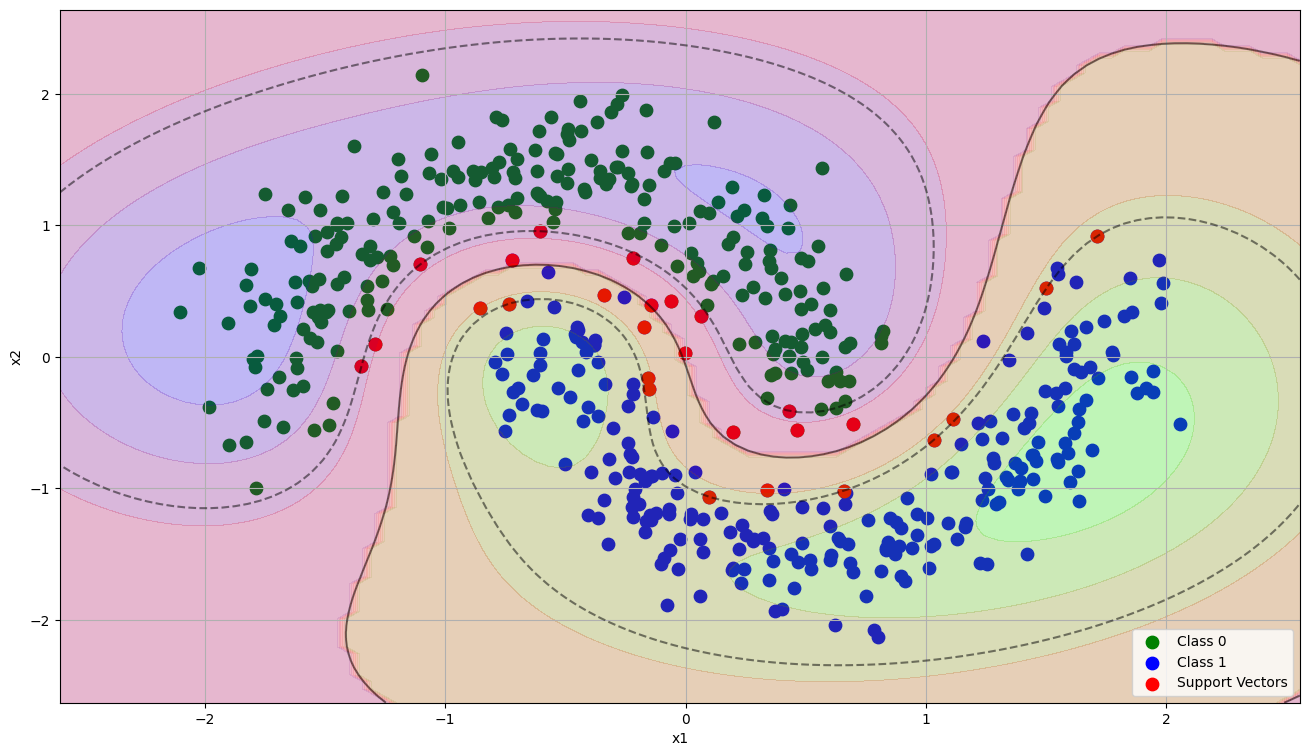

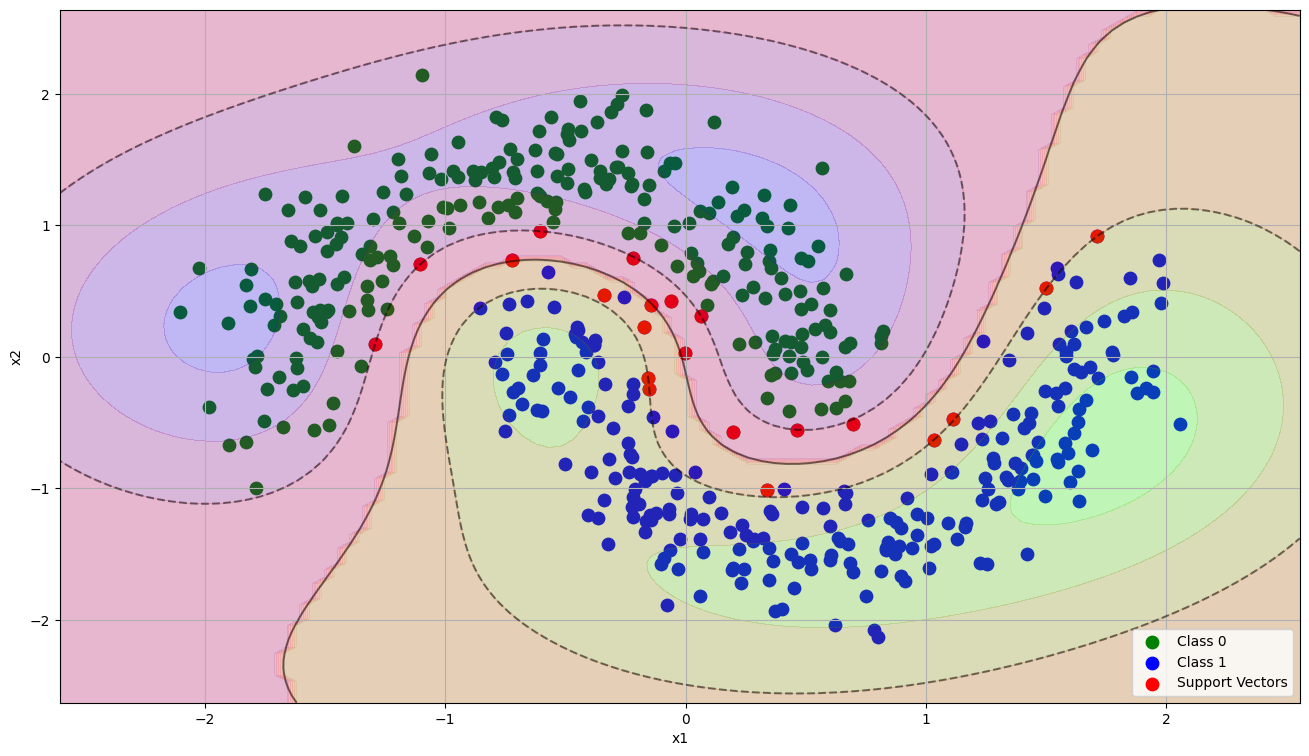

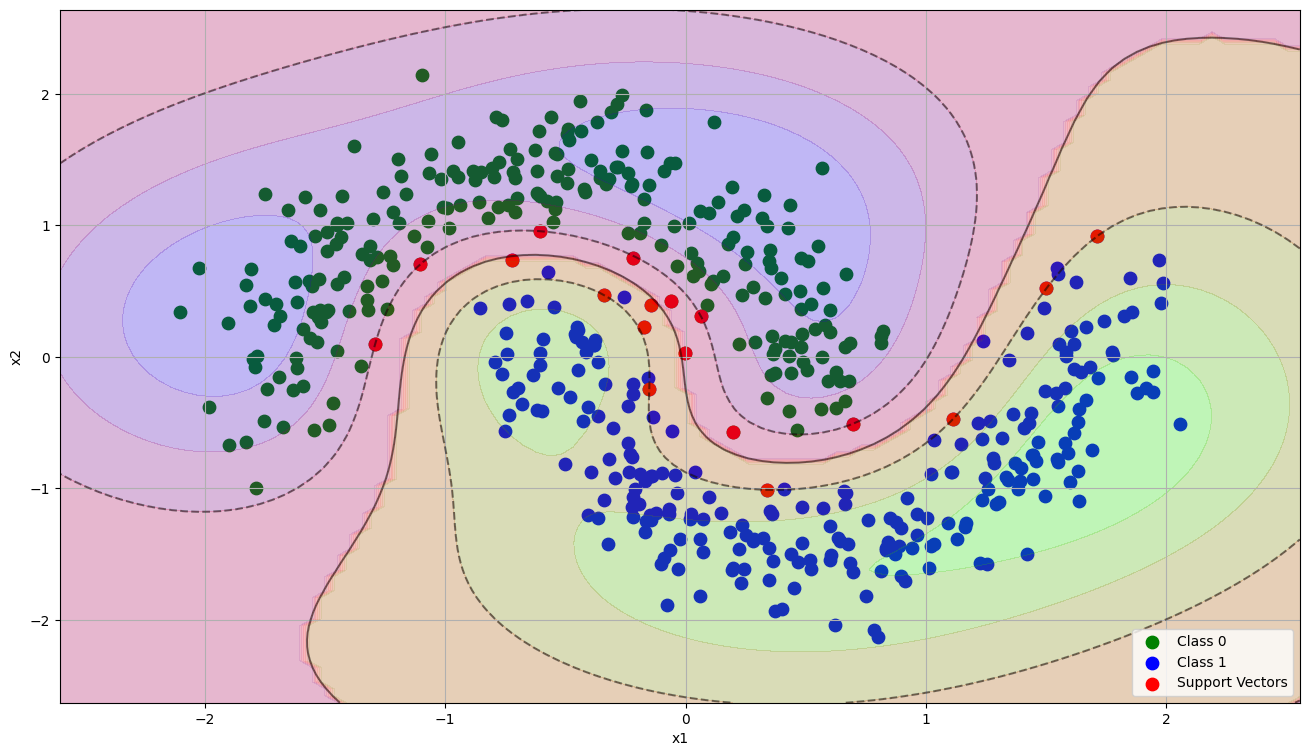

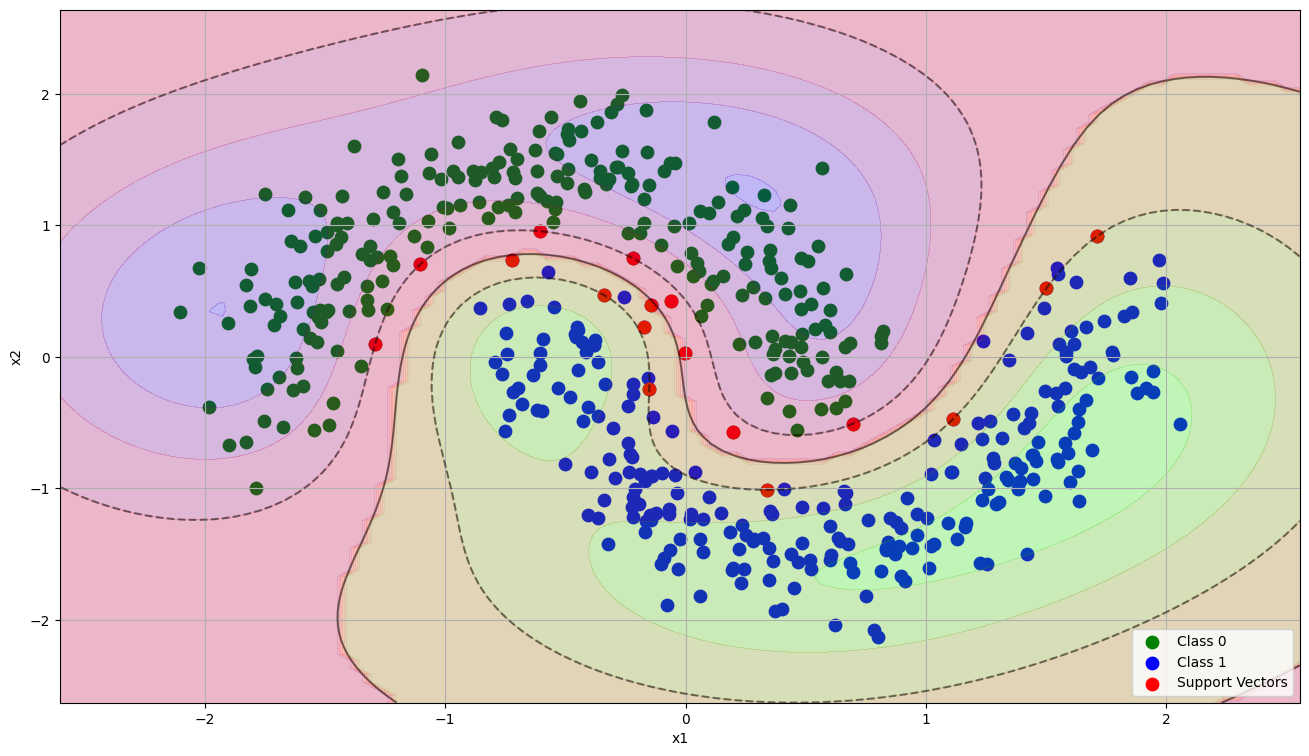

In [13]:
C_values = [0.1, 1, 5, 10, 15, 20]
for C_val in C_values:
    model = SVC(kernel='rbf')
    model.C = C_val
    model.gamma = 0.7086451521631987
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_svm(model, X_train, y_train, X_test, y_test)

hyper-parameter value: {'C':16.27937039885991, gamma': float 0 to 1} 

### Impact of Changing `gamma` in RBF Kernel SVM:

1. **`gamma` = 0**:
   - This is a special case, often interpreted as setting `gamma` to a very small value. The effect is similar to a linear model, leading to a high bias and low variance scenario. The decision boundary will be very simple, possibly underfitting the data.

2. **Low `gamma` Values (e.g., 0.01)**:
   - **Support Vectors**: Tends to use fewer support vectors, as the model is less sensitive to the specific features of the training data.
   - **Decision Boundaries**: More generalized decision boundaries with broader margins.
   - **Complexity**: The model is simpler and less prone to overfitting.
   - **Train and Test Error**: May lead to higher training error but potentially better generalization, resulting in lower test error.

3. **Moderate `gamma` Values (e.g., 0.2, 0.5)**:
   - **Support Vectors**: A moderate number of support vectors are used, indicating a balanced approach to fitting the data.
   - **Decision Boundaries**: More complex than with low `gamma`, but not overly tailored to the training data.
   - **Complexity**: Increased complexity compared to low `gamma`, but still reasonable to avoid severe overfitting.
   - **Train and Test Error**: Generally offers a good balance between training and test accuracy.

4. **High `gamma` Values (e.g., 0.8, 1)**:
   - **Support Vectors**: More support vectors are likely to be used as the model becomes highly sensitive to the training data.
   - **Decision Boundaries**: Highly complex and tightly fitted to the training data, with narrow margins.
   - **Complexity**: Increased model complexity, with a high risk of overfitting.
   - **Train and Test Error**: High training accuracy but potentially high test error due to overfitting.



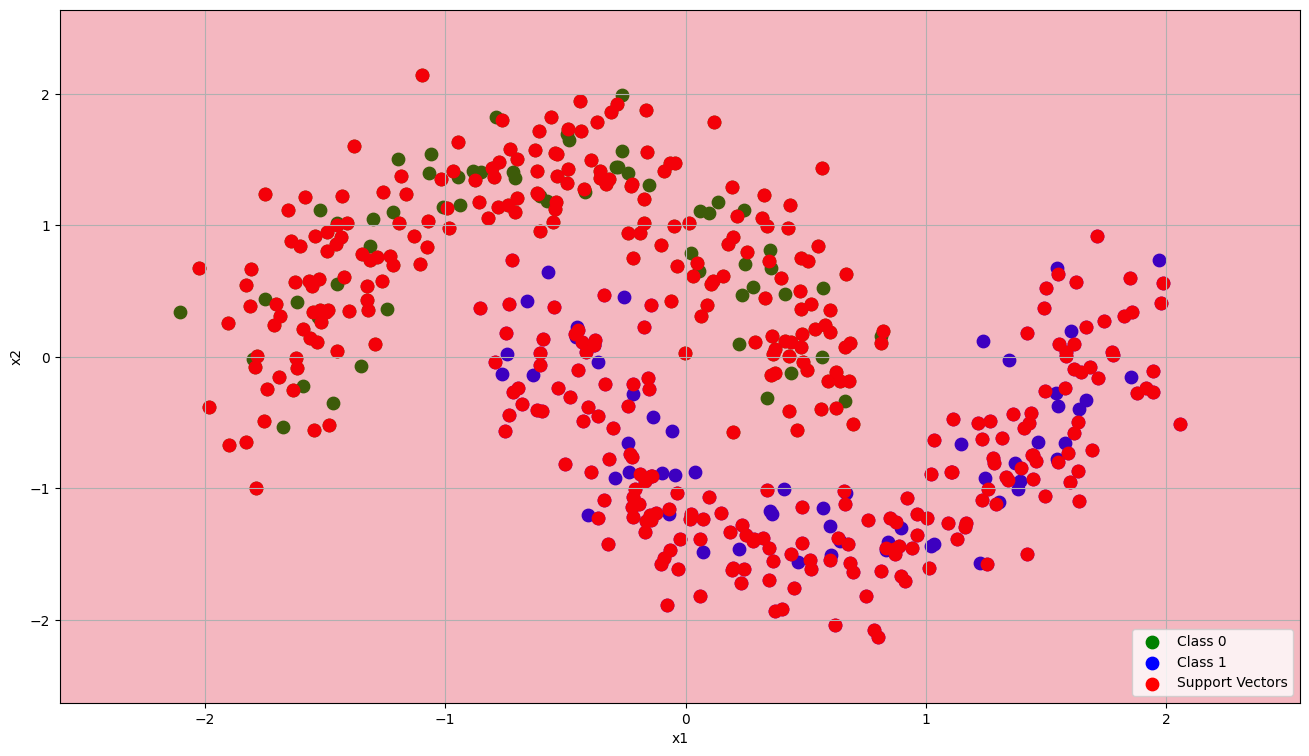

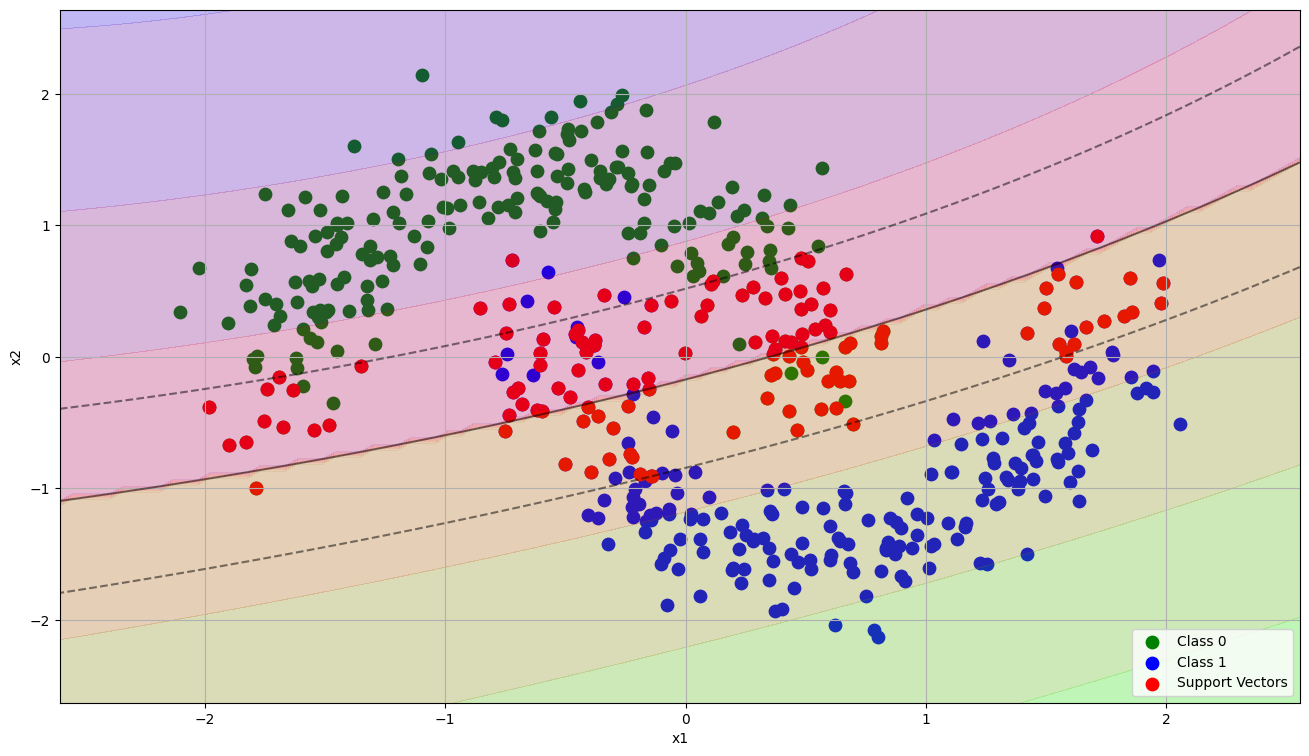

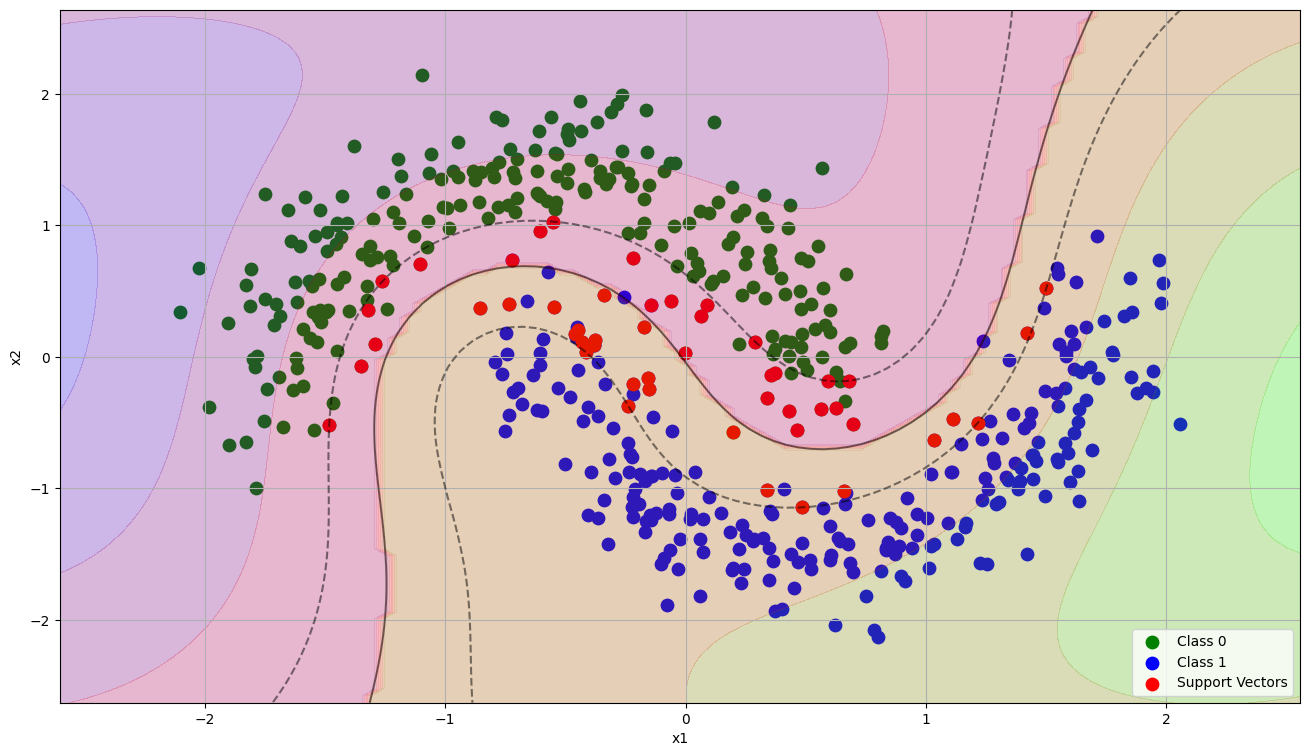

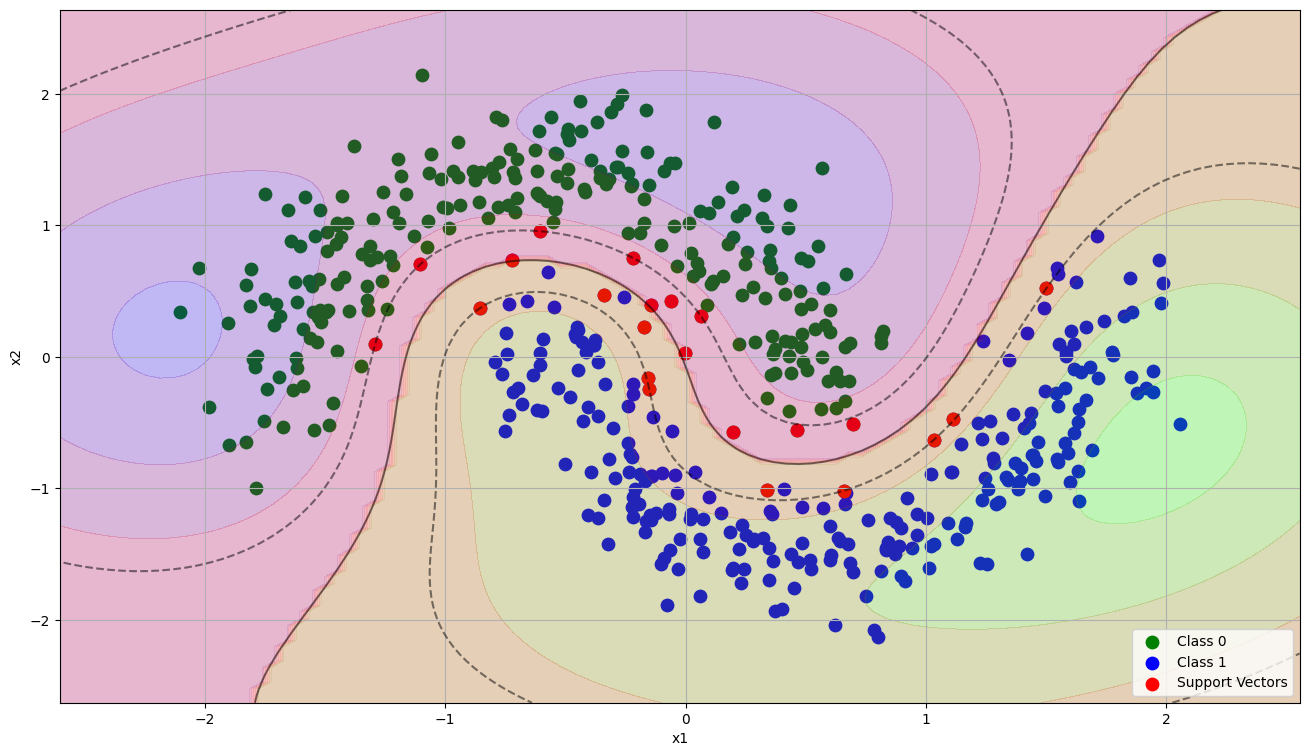

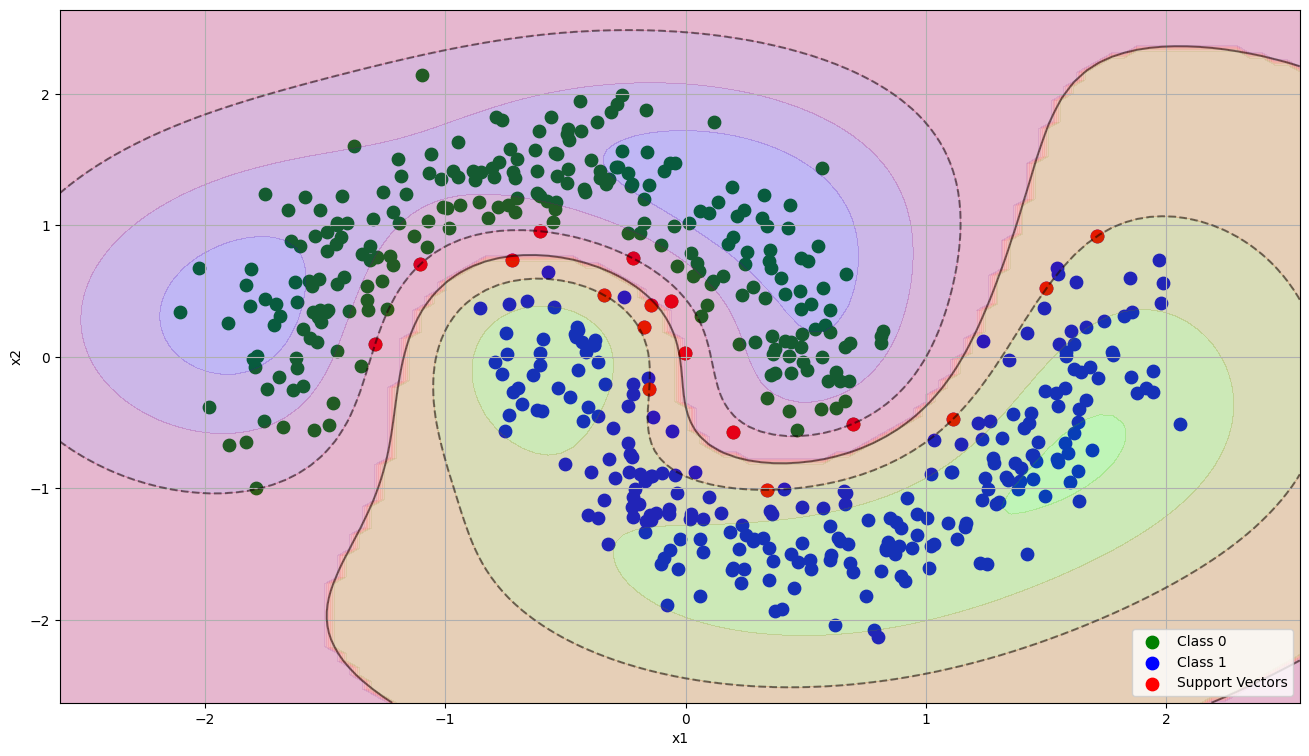

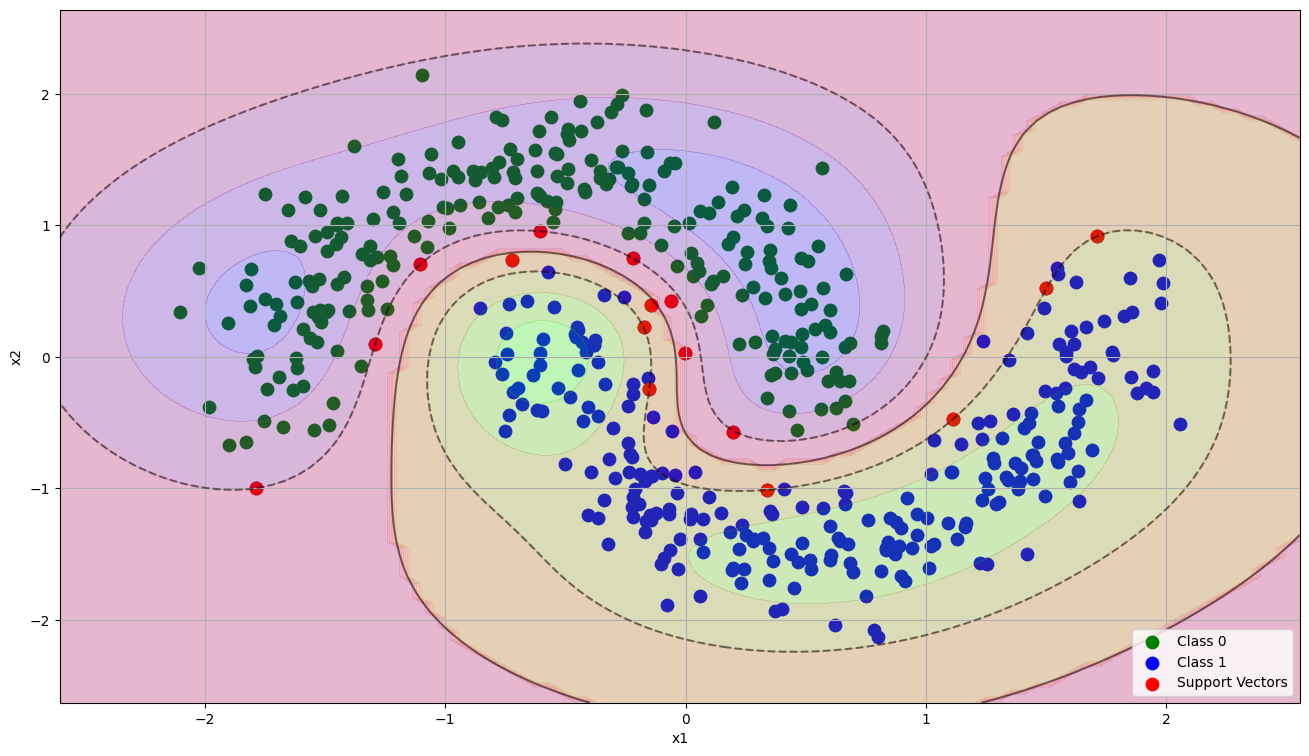

In [14]:
gamma_values = [0, 0.01, 0.2, 0.5, 0.8, 1]
for gamma_val in gamma_values:
    model = SVC(kernel='rbf')
    model.C = 16.27937039885991
    model.gamma = gamma_val
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_svm(model, X_train, y_train, X_test, y_test)